In [2]:
# libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# Astropy
import astropy.coordinates as coord
import astropy.units as u
from astropy.constants import G


# Gala
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from gala.potential.scf import compute_coeffs


In [3]:
# Design gala potential using Nbody and a test particle


# Present-day position/velocity in inertial frame moving with instantaneous 
# Milky Way velocity:
w0_mw = gd.PhaseSpacePosition(
    pos=[0, 0, 0]*u.kpc,
    vel=[0, 0, 0]*u.km/u.s,
)
pot_mw = gp.HernquistPotential(m=1e12*u.Msun, c=1*u.kpc, units=galactic)

# Values from Vasiliev et al. 2020
w0_lmc = gd.PhaseSpacePosition(
    pos=[1200, 200, 0]*u.kpc,
    vel=[-300, 0, 0]*u.km/u.s,
)

w0_test = gd.PhaseSpacePosition(
    pos=[1230, 200, 0]*u.kpc,
    vel=[-300, 80, 0]*u.km/u.s,
)


pot_lmc = gp.HernquistPotential(m=1e11*u.Msun, c=1*u.kpc, units=galactic)

w0 = gd.combine((w0_mw, w0_lmc, w0_test))
nbody = gd.DirectNBody(w0, [pot_mw, pot_lmc, None])

In [4]:
# Compute orbit in gala potential
w1 = gd.combine((w0_lmc, w0_test))
isolated = gd.DirectNBody(w1, [pot_lmc, None])

In [5]:
dt = 0.1*u.Myr
tmax = 8*u.Gyr
nsteps = int((tmax/dt).to(u.Gyr/u.Gyr).value)
t_orbit = np.linspace(0, tmax, nsteps)


# Full : Host - Satellite - test particle 
orbits = nbody.integrate_orbit(dt=dt, t1=0*u.Gyr, t2=tmax)

# Isolated : Satellite - test particle 
orbits_iso = isolated.integrate_orbit(dt=dt, t1=0*u.Gyr, t2=tmax)


In [6]:
# Orbit quantities full orbit 
pos_halo = np.array([orbits.xyz[:,:,0].to(u.kpc).value])
pos_sat = np.array([orbits.xyz[:,:,1].to(u.kpc).value])
pos_tp = np.array([orbits.xyz[:,:,2].to(u.kpc).value])

vel_halo = np.array([orbits.v_xyz[:,:,0].to(u.km/u.s).value])
vel_sat = np.array([orbits.v_xyz[:,:,1].to(u.km/u.s).value])
vel_tp = np.array([orbits.v_xyz[:,:,2].to(u.km/u.s).value])


r_halo = (np.sum(orbits.xyz[:,:,0]**2, axis=0))**0.5
r_sat = (np.sum(orbits.xyz[:,:,1]**2, axis=0))**0.5
r_tp = (np.sum(orbits.xyz[:,:,2]**2, axis=0))**0.5

v_halo = (np.sum(orbits.v_xyz[:,:,0].to(u.km/u.s).value**2, axis=0))**0.5
v_sat = (np.sum(orbits.v_xyz[:,:,1].to(u.km/u.s).value**2, axis=0))**0.5
v_tp = (np.sum(orbits.v_xyz[:,:,2].to(u.km/u.s).value**2, axis=0))**0.5


# Orbit quantities isolated case
pos_sat_iso = np.array([orbits_iso.xyz[:,:,0].to(u.kpc).value])
pos_tp_iso = np.array([orbits_iso.xyz[:,:,1].to(u.kpc).value])

vel_sat_iso = np.array([orbits_iso.v_xyz[:,:,0].to(u.km/u.s).value])
vel_tp_iso = np.array([orbits_iso.v_xyz[:,:,1].to(u.km/u.s).value])


r_sat_iso = (np.sum(orbits_iso.xyz[:,:,0].to(u.kpc).value**2, axis=0))**0.5
r_tp_iso = (np.sum(orbits_iso.xyz[:,:,1].to(u.kpc).value**2, axis=0))**0.5

v_sat_iso = (np.sum(orbits_iso.v_xyz[:,:,0].to(u.km/u.s).value**2, axis=0))**0.5
v_tp_iso = (np.sum(orbits_iso.v_xyz[:,:,1].to(u.km/u.s).value**2, axis=0))**0.5


In [7]:
# relative quantities with respect to the satellite full case
rtp_r2_sat = np.sum((np.array(orbits.xyz[:,:,2].to(u.kpc).value-orbits.xyz[:,:,1].to(u.kpc).value))**2, axis=0)**0.5
vtp_r2_sat = np.sum((np.array(orbits.v_xyz[:,:,2].to(u.km/u.s)-orbits.v_xyz[:,:,1].to(u.km/u.s)))**2, axis=0)**0.5

# relative quantities with respect to the satellite isolated case
rtp_r2_sat_iso = np.sum((np.array(orbits_iso.xyz[:,:,1].to(u.kpc).value-orbits_iso.xyz[:,:,0].to(u.kpc).value))**2, axis=0)**0.5
vtp_r2_sat_iso = np.sum((np.array(orbits_iso.v_xyz[:,:,1].to(u.km/u.s)-orbits_iso.v_xyz[:,:,0].to(u.km/u.s)))**2, axis=0)**0.5


In [8]:
pos_halo[:,1][0]

array([0.00000000e+00, 2.49443663e-10, 9.97799460e-10, ...,
       6.25870080e+01, 6.25883990e+01, 6.25897901e+01])

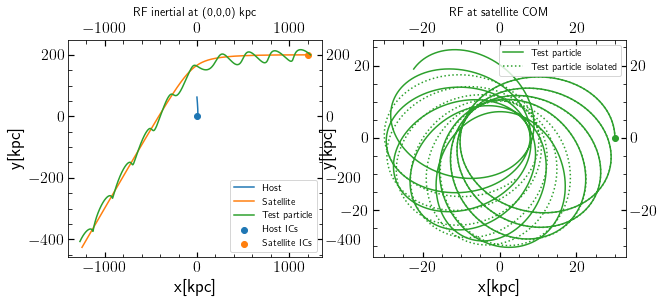

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))


ax[0].plot(pos_halo[:,0][0], pos_halo[:,1][0], label='Host')
ax[0].plot(pos_sat[:,0][0], pos_sat[:,1][0], label='Satellite')
ax[0].plot(pos_tp[:,0][0], pos_tp[:,1][0], label='Test particle')


ax[0].scatter(pos_halo[:,0][0][0], pos_halo[:,1][0][0], label='Host ICs')
ax[0].scatter(pos_sat[:,0][0][0], pos_sat[:,1][0][0], label='Satellite ICs')



ax[1].plot(pos_tp[:,0][0]-pos_sat[:,0][0], pos_tp[:,1][0]-pos_sat[:,1][0], c='C2', label='Test particle')
ax[1].scatter(pos_tp[:,0][0][0]-pos_sat[:,0][0][0], pos_tp[:,1][0][0]-pos_sat[:,1][0][0], c='C2')

ax[1].plot(pos_tp_iso[:,0][0]-pos_sat_iso[:,0][0], pos_tp_iso[:,1][0]-pos_sat_iso[:,1][0], c='C2', ls=':',
           label='Test particle isolated')


ax[0].set_xlabel('x[kpc]')
ax[0].set_ylabel('y[kpc]')
ax[0].set_title('RF inertial at (0,0,0) kpc')
ax[0].legend()

ax[1].set_xlabel('x[kpc]')
ax[1].set_ylabel('y[kpc]')
ax[1].set_title('RF at satellite COM')
ax[1].legend()


Text(0.5, 0, 'Time [Gyrs]')

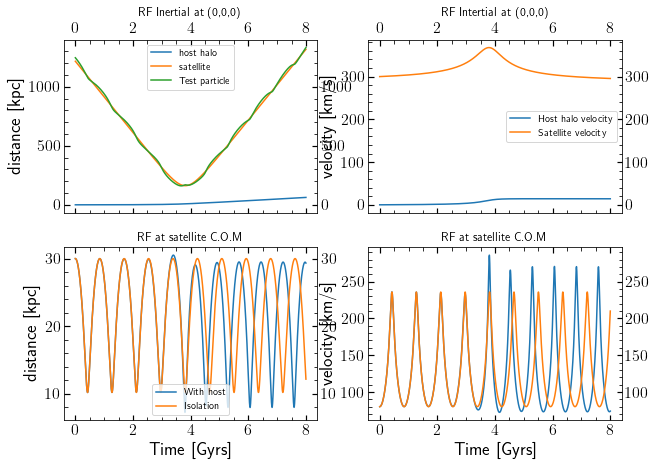

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True)


ax[0][0].plot(t_orbit, r_halo, label='host halo')
ax[0][0].plot(t_orbit, r_sat, label='satellite')
ax[0][0].plot(t_orbit, r_tp, label='Test particle')
ax[0][0].legend()
ax[0][0].set_title('RF Inertial at (0,0,0)')
ax[0][0].set_ylabel('distance [kpc]')

ax[0][1].plot(t_orbit, v_halo, label='Host halo velocity')
ax[0][1].plot(t_orbit, v_sat, label='Satellite velocity')
ax[0][1].set_title('RF Intertial at (0,0,0)')
ax[0][1].legend()
ax[0][1].set_ylabel('velocity [km/s]')


ax[1][0].set_title('RF at satellite C.O.M')
ax[1][0].plot(t_orbit, rtp_r2_sat, label='With host')
ax[1][0].plot(t_orbit, rtp_r2_sat_iso, label='Isolation')
ax[1][0].legend(loc='lower center')
ax[1][0].set_ylabel('distance [kpc]')


ax[1][1].set_title('RF at satellite C.O.M')
ax[1][1].plot(t_orbit, vtp_r2_sat)
ax[1][1].plot(t_orbit, vtp_r2_sat_iso)
ax[1][1].set_ylabel('velocity [km/s]')


ax[1][0].set_xlabel('Time [Gyrs]')
ax[1][1].set_xlabel('Time [Gyrs]')


In [11]:
# Compute expansion from potential

In [12]:
## MW potential definition
#    mw_potential = gp.CCompositePotential()
#    mw_potential['bulge'] = gp.HernquistPotential(m=5E9, c=1., units=galactic)
#    mw_potential['disk'] = gp.MiyamotoNagaiPotential(m=6.8E10*u.Msun, a=3*u.kpc, b=280*u.pc,                                                     units=galactic)
#    mw_potential['nucl'] = gp.HernquistPotential(m=np.exp(log_M_n), c=np.exp(log_a)*u.pc,                                                 units=galactic)
#    mw_potential['halo'] = gp.NFWPotential(m=np.exp(log_M_h), r_s=np.exp(log_r_s), units=galactic)


In [13]:
# Hernquist halo for satellite
def density_func(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2) # * u.kpc
    M = 1E11 # u.Msun 
    rs = 1 #*u.kpc
    rho0 = M/(2*np.pi*rs**3)
    return rho0 / ((r/rs) *(1+r/rs)**3)
    

In [14]:
# Check MW halo density
rr = np.linspace(0, 100, 100)
rho_sat_scf = density_func(rr, 0, 0)
rho_lmc =  pot_lmc.density(np.array([rr, np.zeros(100), np.zeros(100)]))

/tmp/ipykernel_42268/162232498.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return rho0 / ((r/rs) *(1+r/rs)**3)


In [15]:
# Compute coefficients 
nmax=10
lmax=1
scf_coeffs = compute_coeffs(density_func, nmax=nmax, lmax=lmax, M=1E11, r_s=1)

In [16]:
S = scf_coeffs[0][0]
T = scf_coeffs[1][0]

In [18]:
sat_com = pos_sat[0].T - pos_sat[0][:,0]
sat_vcom = np.zeros_like(sat_com)*u.km/u.s

In [68]:
sat_scf = gp.scf.SCFPotential(m=1E11*u.Msun, r_s=1*u.kpc, Snlm=S, Tnlm=T, units=galactic)

sat_scf_tdp = gp.scf.InterpolatedSCFPotential(m=1E11*u.Msun, r_s=1*u.kpc, Sjnlm=S_interp, Tjnlm=T_interp, 
                                              tj=np.linspace(0, 8, nsnaps)*u.Gyr, com_xj=0, com_vj=0,
                                              units=galactic)



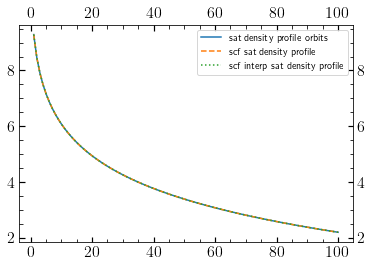

In [51]:
sat_scf_density = sat_scf.density(np.array([rr, np.zeros(100), np.zeros(100)]))
sat_scf_tdp_density = sat_scf_tdp_mov.density(np.array([rr, np.zeros(100), np.zeros(100)]))

plt.plot(rr, np.log10(rho_lmc.value), label='sat density profile orbits')
plt.plot(rr, np.log10(sat_scf_density.value), label='scf sat density profile', ls='--')
plt.plot(rr, np.log10(sat_scf_tdp_density.value), label='scf interp sat density profile', ls=':')

plt.legend()


In [89]:
w0_scf = gd.PhaseSpacePosition(
    pos=[30, 0, 0]*u.kpc,
    vel=[0, 80, 0]*u.km/u.s,
)



In [71]:
orbit_scf = gp.Hamiltonian(sat_scf).integrate_orbit(w0_scf, dt=dt, t1=0*u.Gyr, t2=tmax)
pos_scf = orbit_scf.xyz.value.T
vel_scf = orbit_scf.v_xyz.to(u.km/u.s).value.T

r_scf = (np.sum(pos_scf**2, axis=1))**0.5
v_scf = (np.sum(vel_scf**2, axis=1))**0.5

In [72]:
orbit_scf_tdp = gp.Hamiltonian(sat_scf_tdp).integrate_orbit(w0_scf, dt=dt, t1=0*u.Gyr, t2=tmax)
pos_scf_tdp = orbit_scf_tdp.xyz.value.T
vel_scf_tdp = orbit_scf_tdp.v_xyz.to(u.km/u.s).value.T

r_scf_tdp = (np.sum(pos_scf_tdp**2, axis=1))**0.5
v_scf_tdp = (np.sum(vel_scf_tdp**2, axis=1))**0.5

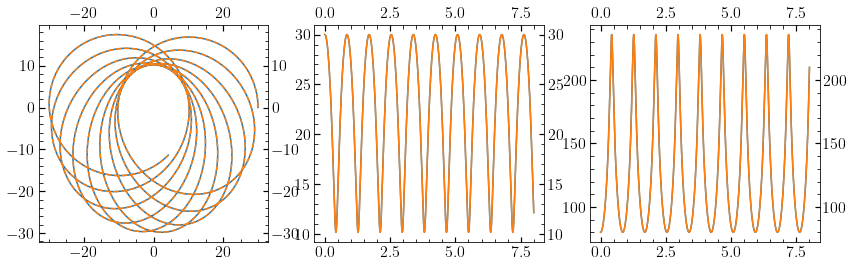

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].plot(pos_tp_iso[:,0][0]-pos_sat_iso[:,0][0], pos_tp_iso[:,1][0]-pos_sat_iso[:,1][0])
ax[0].plot(pos_scf[:,0], pos_scf[:,1], ls='--')

ax[1].plot(t_orbit, rtp_r2_sat_iso, label='Isolation')
ax[1].plot(t_orbit, r_scf)


ax[2].plot(t_orbit, vtp_r2_sat_iso, label='Isolation')
ax[2].plot(t_orbit, v_scf)

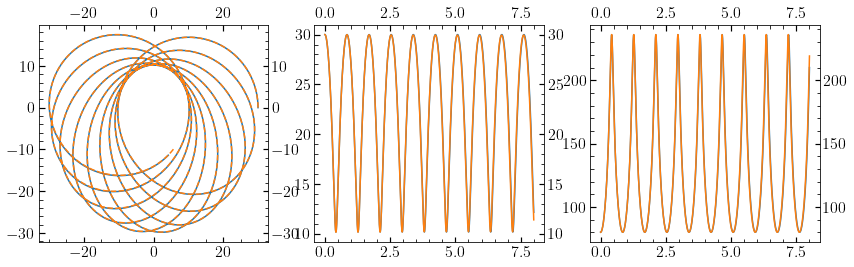

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].plot(pos_tp_iso[:,0][0]-pos_sat_iso[:,0][0], pos_tp_iso[:,1][0]-pos_sat_iso[:,1][0])
ax[0].plot(pos_scf_tdp[:,0], pos_scf_tdp[:,1], ls='--')

ax[1].plot(t_orbit, rtp_r2_sat_iso, label='Isolation')
ax[1].plot(t_orbit, r_scf_tdp)


ax[2].plot(t_orbit, vtp_r2_sat_iso, label='Isolation')
ax[2].plot(t_orbit, v_scf_tdp)

In [ ]:
w0_scf_mov = gd.PhaseSpacePosition(
    pos=[30, 0, 0]*u.kpc,
    vel=[-300, 80, 0]*u.km/u.s,
)

#nsnaps = 1000
nsnaps = nsteps
S_interp = np.zeros((nsnaps, nmax+1, lmax+1, lmax+1))
T_interp = np.zeros((nsnaps, nmax+1, lmax+1, lmax+1))

for n in range(nsnaps):
    S_interp[n] = S


sat_scf_tdp_mov = gp.scf.InterpolatedSCFPotential(m=1E11*u.Msun, r_s=1*u.kpc, Sjnlm=S_interp, Tjnlm=T_interp, 
                                              tj=np.linspace(0, 8, nsnaps)*u.Gyr, com_xj=sat_com*u.kpc, com_vj=sat_vcom,
                                              units=galactic)

orbit_scf_tdp_mov = gp.Hamiltonian(sat_scf_tdp_mov).integrate_orbit(w0_scf_mov, dt=dt, t1=0*u.Gyr, t2=tmax)
pos_scf_tdp_mov = orbit_scf_tdp_mov.xyz.value.T
vel_scf_tdp_mov = orbit_scf_tdp_mov.v_xyz.to(u.km/u.s).value.T

r_scf_tdp_mov = (np.sum(pos_scf_tdp_mov**2, axis=1))**0.5
v_scf_tdp_mov = (np.sum(vel_scf_tdp_mov**2, axis=1))**0.5

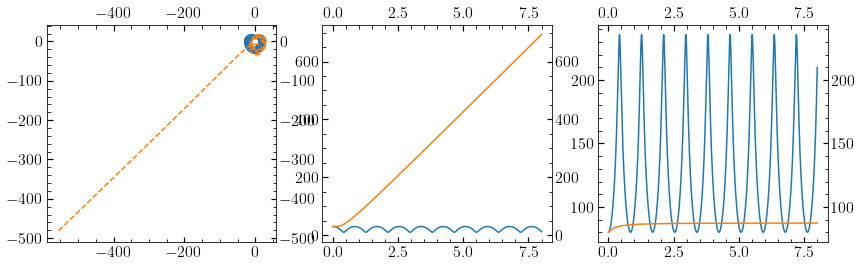

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].plot(pos_tp_iso[:,0][0]-pos_sat_iso[:,0][0], pos_tp_iso[:,1][0]-pos_sat_iso[:,1][0])
ax[0].plot(pos_scf_tdp_mov[:,0]-sat_com[:,0], pos_scf_tdp_mov[:,1], ls='--')

ax[1].plot(t_orbit, rtp_r2_sat_iso, label='Isolation')
ax[1].plot(t_orbit, r_scf_tdp_mov)


ax[2].plot(t_orbit, vtp_r2_sat_iso, label='Isolation')
ax[2].plot(t_orbit, v_scf_tdp_mov)

(-30.0, 20.0)

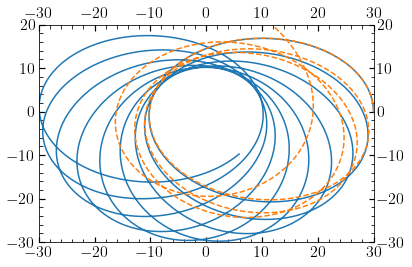

In [101]:
plt.plot(pos_scf_tdp[:,0], pos_scf_tdp[:,1], ls='-')
plt.plot(pos_scf_tdp_mov[:,0]-sat_com[:,0], pos_scf_tdp_mov[:,1]-sat_com[:,1], ls='--')

plt.xlim(-30, 30)
plt.ylim(-30, 20)

In [145]:
w0_scf_mov = gd.PhaseSpacePosition(
    pos=[30, 0, 0]*u.kpc,
    vel=[-300, 80, 0]*u.km/u.s,
)

#nsnaps = 1000
nsnaps = nsteps
S_interp = np.zeros((nsnaps, nmax+1, lmax+1, lmax+1))
T_interp = np.zeros((nsnaps, nmax+1, lmax+1, lmax+1))

for n in range(nsnaps):
    S_interp[n] = S


sat_scf_tdp_mov = gp.scf.InterpolatedSCFPotential(m=1E11*u.Msun, r_s=1*u.kpc, Sjnlm=S_interp, Tjnlm=T_interp, 
                                              tj=np.linspace(0, 8, nsnaps)*u.Gyr, com_xj=sat_com*u.kpc, com_vj=sat_vcom,
                                              units=galactic)

orbit_scf_tdp_mov = gp.Hamiltonian(sat_scf_tdp_mov).integrate_orbit(w0_scf_mov, dt=dt, t1=0*u.Gyr, t2=tmax)
pos_scf_tdp_mov = orbit_scf_tdp_mov.xyz.value.T
vel_scf_tdp_mov = orbit_scf_tdp_mov.v_xyz.to(u.km/u.s).value.T

r_scf_tdp_mov = (np.sum(pos_scf_tdp_mov**2, axis=1))**0.5
v_scf_tdp_mov = (np.sum(vel_scf_tdp_mov**2, axis=1))**0.5

array([ 0.00000000e+00, -3.06813799e-02, -6.13627898e-02, ...,
       -2.44632670e+03, -2.44635354e+03, -2.44638038e+03])

In [118]:
def density_func_host(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2) # * u.kpc
    M = 1E12 # u.Msun 
    rs = 1 #*u.kpc
    rho0 = M/(2*np.pi*rs**3)
    return rho0 / ((r/rs) *(1+r/rs)**3)

nmax=10
lmax=1
scf_coeffs_host = compute_coeffs(density_func_host, nmax=nmax, lmax=lmax, M=1E12, r_s=1)

In [119]:
S_host = scf_coeffs_host[0][0]
T_host = scf_coeffs_host[1][0]


nsnaps = nsteps
S_interp_host = np.zeros((nsnaps, nmax+1, lmax+1, lmax+1))
T_interp_host = np.zeros((nsnaps, nmax+1, lmax+1, lmax+1))

for n in range(nsnaps):
    S_interp_host[n] = S_host


In [125]:
host_com = pos_halo[0].T
host_vcom = np.zeros_like(host_com)*u.km/u.s


sat_com = pos_sat[0].T
sat_vcom = np.zeros_like(sat_com)*u.km/u.s

In [126]:
host_scf_tdp_mov = gp.scf.InterpolatedSCFPotential(m=1E12*u.Msun, r_s=1*u.kpc, Sjnlm=S_interp_host, Tjnlm=T_interp_host, 
                                              tj=np.linspace(0, 8, nsnaps)*u.Gyr, com_xj=host_com*u.kpc, com_vj=host_vcom,
                                              units=galactic)

# This is re-writing the potential defined before
sat_scf_tdp_mov = gp.scf.InterpolatedSCFPotential(m=1E11*u.Msun, r_s=1*u.kpc, Sjnlm=S_interp, Tjnlm=T_interp, 
                                              tj=np.linspace(0, 8, nsnaps)*u.Gyr, com_xj=sat_com*u.kpc, com_vj=sat_vcom,
                                              units=galactic)


w0_scf_comp = gd.PhaseSpacePosition(
    pos=[1230, 200, 0]*u.kpc,
    vel=[-300, 80, 0]*u.km/u.s,
)

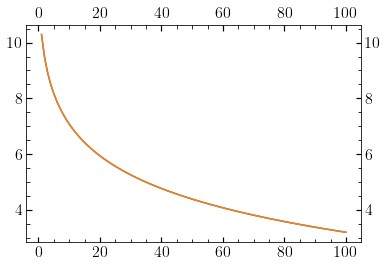

In [127]:
host_scf_tdp_density = host_scf_tdp_mov.density(np.array([rr, np.zeros(100), np.zeros(100)]))
rho_halo = pot_mw.density(np.array([rr, np.zeros(100), np.zeros(100)]))


plt.plot(rr, np.log10(rho_halo.value), label='sat density profile orbits')
plt.plot(rr, np.log10(host_scf_tdp_density.value))

In [128]:
scf_comp_pot = gp.CCompositePotential(host=host_scf_tdp_mov, satellite=sat_scf_tdp_mov)

In [130]:
orbit_scf_comp_tdp_mov = gp.Hamiltonian(scf_comp_pot).integrate_orbit(w0_scf_comp, dt=dt, t1=0*u.Gyr, t2=tmax)
pos_scf_comp_tdp_mov = orbit_scf_comp_tdp_mov.xyz.value.T
vel_scf_comp_tdp_mov = orbit_scf_comp_tdp_mov.v_xyz.to(u.km/u.s).value.T

r_scf_comp_tdp_mov = (np.sum(pos_scf_comp_tdp_mov**2, axis=1))**0.5
v_scf_comp_tdp_mov = (np.sum(vel_scf_comp_tdp_mov**2, axis=1))**0.5

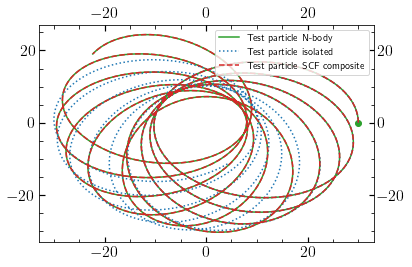

In [138]:
plt.plot(pos_tp[:,0][0]-pos_sat[:,0][0], pos_tp[:,1][0]-pos_sat[:,1][0], c='C2', label='Test particle N-body')
plt.scatter(pos_tp[:,0][0][0]-pos_sat[:,0][0][0], pos_tp[:,1][0][0]-pos_sat[:,1][0][0], c='C2')

plt.plot(pos_tp_iso[:,0][0]-pos_sat_iso[:,0][0], pos_tp_iso[:,1][0]-pos_sat_iso[:,1][0], c='C0', ls=':',
           label='Test particle isolated')

plt.plot(pos_scf_comp_tdp_mov[:,0]-pos_sat[:,0][0], pos_scf_comp_tdp_mov[:,1]-pos_sat[:,1][0], c='C3', ls='--',
        label='Test particle SCF composite')

plt.legend()


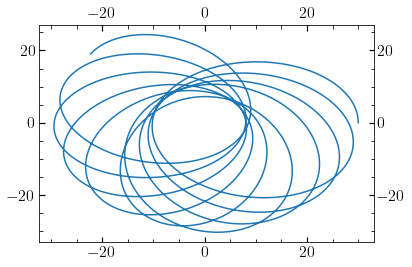